# Powerplant Optimization with Differential Evolution

All information is taken from "Differential Evolution: A Survey of the State-of-the-Art"by Swagatam Das, Member, IEEE, and Ponnuthurai Nagaratnam Suganthan, Senior Member, IEEE.

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

We aim to optimize two parameters: the scaling factor (mutation) and the crossover probability. Moreover, we consider different instantiations.

Note that we consider the scaling factor $\in [0.4, 1]$. The reason for that is that finding an optimal solutions is difficult for a scaling factor greater than $1$ since we have "big steps". For a scaling factor smaller than $0.4$ these steps are considerably small and therefore increase the run time drastically .

## 1. Initialization 

Randomly initiated population of real-valued parameter vectors. Each vector, called chromosome, forms a candidate solution to the multidimensional optimization problem.

In [36]:
def initialize(population_size_NP,p1,p2,p3,d1,d2,d3):
    # TODO: randomly initialize a population of NP individuals within the domain
    population = []
    random_chromosome = []
    for i in range(population_size_NP):
        random_chromosome = []
        # initialize energy produced:
        random_chromosome.append(random.uniform(0,5000000))
        random_chromosome.append(random.uniform(0,30000000))
        random_chromosome.append(random.uniform(0,12000000))
        
        # initialize demands
        random_chromosome.append(random.uniform(0,d1))
        random_chromosome.append(random.uniform(0,d2))
        random_chromosome.append(random.uniform(0,d3))
        
        # initialize prices
        random_chromosome.append(random.uniform(0,p1))
        random_chromosome.append(random.uniform(0,p2))
        random_chromosome.append(random.uniform(0,p3))
        
        population.append(random_chromosome)
    
    return population

In [3]:
print(initialize(3))

[[4550304.688871899, 5045470.939358717, 2015161.2279736511, 804158.0538853108, 8234556.66785618, 965014.2157892394, 0.3504228968266534, 0.13917102656134822, 0.11606546823832567], [4954970.472602943, 8612984.890079692, 10426923.79596451, 1490582.0518174537, 6428087.471652197, 19960822.44431732, 0.08093095005827282, 0.05291435311992573, 0.14800236602552166], [4039641.119605775, 21675037.889292143, 268923.94748472894, 663883.249326636, 15688691.220601108, 17148767.195971966, 0.08374629688330237, 0.042224937359340964, 0.19977566058211516]]


## 2. Mutation

In [4]:
def mutate(target_vector_X,scale_factor_F,population):
    #target_vector_X,scale_factor_F,population_size_NP,population
    # TODO: Generate a donor vector according to the mutation scheme with scale Factor F
    
    # NOT FINISHED !!!
    population_size_NP = len(population)
    param_vectors = []
    vectors_used = 0
    while vectors_used < 3:
        rand = random.randint(0, population_size_NP-1)
        new_vector = population[rand]
        
        # check if new_vector is not the target_vector_X and not already chosen for param_vectors
        # (new_vector!=param_vectors).all() or this one //// if-statement not working
        #if np.all((new_vector != target_vector_X)) and (np.array_equiv(new_vector, param_vectors)):
        if not np.array_equiv(new_vector,target_vector_X):
            if vectors_used == 0:
                param_vectors.append(new_vector)
                vectors_used += 1
            else:
                for i in range(vectors_used):
                    if not np.array_equiv(new_vector, param_vectors[i]):
                        param_vectors.append(new_vector)
                        vectors_used += 1
                        break

    donor_vector_V = param_vectors[0] + scale_factor_F*(param_vectors[1]-param_vectors[2])
    
    return donor_vector_V

In [5]:
target_vector_X = [50,40,30,20]
scale_factor_F = 0.5
population = np.array([[10,20,30,40], [30,40,50,60], [10,10,20,20], [30,30,30,30], [90,30,10,10], [20,20,30,40], [50,50,50,0], [40,40,30,30], [90,80,40,10], [40,40,70,80]])
    
print(mutate(target_vector_X,scale_factor_F,population))

[ 15.  20.  65.  90.]


## 3. Crossover / Recombination

In [6]:
def crossover(target_vector_X,donor_vector_V,cross_over_rate_Cr):
    # TODO: Generate a trial vector through binomial crossover
    trial_vector_U = np.copy(target_vector_X)
    D = len(target_vector_X)
    for j in range(D):
        j_rand = random.randint(1,D)
        if (random.random() <= cross_over_rate_Cr) or j == j_rand :
            trial_vector_U[j] = donor_vector_V[j]
            #print("donor_vector ",j)
        else:
            trial_vector_U[j] = target_vector_X[j]
            #print("target__vector ",j)
    return trial_vector_U

In [7]:
target_vector_X = [1,1,1,1,1,1,1,1,1]
donor_vector_V = [2,2,2,2,2,2,2,2,2]
cross_over_rate_Cr = 0.5
print(crossover(target_vector_X,donor_vector_V,cross_over_rate_Cr))

[2 2 2 2 2 2 1 1 1]


## 4. Selection

In [8]:
def demand(price, maxPrice, maxDemand):
    if(price > maxPrice):
        return 0
    
    if(price <= 0):
        return maxDemand
    
    demand = maxDemand - price**2 * maxDemand / maxPrice**2
    
    return demand

In [48]:
def cost(x, kwhPerPlant, costPerPlant, maxPlants):
    if(x <= 0):
        return 0
    
    if(x > kwhPerPlant * maxPlants):
        return float("Inf")
    
    plantsNeeded = math.ceil(x / kwhPerPlant)
    
    return plantsNeeded * costPerPlant

In [37]:
def objective(tested_vector,cost_price,p1,p2,p3,d1,d2,d3):
    
    # each e already provides the sum of energy produced per plant type
    total_energy_produced = tested_vector[0] + tested_vector[1] + tested_vector[2]
    
    total_energy_planned =  tested_vector[3] + tested_vector[4] + tested_vector[5]
    
    purchasing_cost = max((total_energy_planned-total_energy_produced),0)*cost_price
    
    production_cost = cost(tested_vector[0], 50000, 10000, 100) + cost(tested_vector[1], 600000, 80000, 50) + cost(tested_vector[2], 4000000, 400000, 3)
    
    total_cost = purchasing_cost + production_cost
    
    revenue = min(demand(tested_vector[6], p1, d1), tested_vector[3])*tested_vector[6] + min(demand(tested_vector[7], p2, d2), tested_vector[4])*tested_vector[7] + min(demand(tested_vector[8], p3, d3), tested_vector[5])*tested_vector[8]
    
    #profit equals fitness
    profit = revenue - total_cost
    
    return profit

In [42]:
def select(target_vector_X,trial_vector_U,cost_price,p1,p2,p3,d1,d2,d3):
    # TODO: Evaluate the trial vector and choose new target vector with better value

    if objective(target_vector_X,cost_price,p1,p2,p3,d1,d2,d3) > objective(trial_vector_U,cost_price,p1,p2,p3,d1,d2,d3):
        new_target_vector = target_vector_X
    else:
        new_target_vector = trial_vector_U

    return new_target_vector

## 5. Action

In [44]:
def get_best(new_population,population_size_NP):
    #choose the best one of the final population
    best_chromosome = new_population[0]
    for i in range(population_size_NP):
        if objective(new_population[i],cost_price,p1,p2,p3,d1,d2,d3)>objective(best_chromosome,cost_price,p1,p2,p3,d1,d2,d3):
            best_chromosome = new_population[i]

    return best_chromosome

In [49]:
# set factors:
scale_factor_F = 0.6
cross_over_rate_Cr = 0.9
population_size_NP = 30
cost_price = 0.6

# market prices
p1 = 0.45
p2 = 0.25
p3 = 0.2

# market demands
d1 = 2000000
d2 = 30000000
d3 = 20000000

# Initialization:
generation_number_G = 0
new_population = initialize(population_size_NP,p1,p2,p3,d1,d2,d3)
best_solution_list = []

converged = False
while not converged:
    population = np.copy(new_population)
    for i in range(population_size_NP):
        target_vector_X = population[i]
        
        # Mutation:
        donor_vector_V = mutate(target_vector_X,scale_factor_F,population)
        
        # Crossover:
        trial_vector_U = crossover(target_vector_X,donor_vector_V,cross_over_rate_Cr)
        
        # Selection:
        new_population[i] = select(target_vector_X,trial_vector_U,cost_price,p1,p2,p3,d1,d2,d3)
    
    generation_number_G += 1
    converged = (generation_number_G == 1000)
    #choose the best one of the final population
    best_chromosome = get_best(new_population,population_size_NP)
    best_solution_list.append(objective(best_chromosome,cost_price,p1,p2,p3,d1,d2,d3))
    
print("done!")
print("best Chromosome:")
print(best_chromosome)
print(objective(best_chromosome,cost_price,p1,p2,p3,d1,d2,d3))

done!
best Chromosome:
[ -1.36173019e+24  -3.50285878e+24  -1.53222788e+24  -9.58979354e+35
  -1.55636459e+39   2.28833426e+37  -1.86319576e+33  -1.08740019e+32
  -1.31877498e+29]
1.7102588145e+71


In [50]:
print(best_solution_list)

[-1307235.7004411859, -914686.76500716538, -914686.76500716538, -728744.91559810238, -728744.91559810238, -689825.71769080684, -153593.86656943662, 152220.41901272256, 170840.50698765879, 170840.50698765879, 170840.50698765879, 170840.50698765879, 170840.50698765879, 170840.50698765879, 322296.53518349677, 322296.53518349677, 322296.53518349677, 4827485.7660144214, 4827485.7660144214, 4827485.7660144214, 11447521.447349673, 11447521.447349673, 13766231.055519454, 13766231.055519454, 13766231.055519454, 22048089.493339568, 22048089.493339568, 24232862.41826769, 24232862.41826769, 27403347.993849672, 30297329.303254507, 31161799.557266656, 31161799.557266656, 40526720.984835811, 40526720.984835811, 43009113.540383101, 43009113.540383101, 45591210.967326738, 65147269.609472513, 65147269.609472513, 65602498.12278609, 79759966.312859431, 87834982.722655267, 92407328.909925938, 92407328.909925938, 98759600.876371533, 106622709.32820597, 117332908.02917562, 138323919.82809773, 138323919.82809

## 6. Plot

In [34]:
def simple_plot(best_profit_per_run,minimum_solution,best_solution):
    fig, ax = plt.subplots(figsize=plt.figaspect(0.2))
    ax.plot(best_profit_per_run, ':r', label=f"parameters")
    ax.set(ylim=[minimum_solution,best_solution],ylabel='Profit', xlabel='Iteration', title='DE on Power Plant Optimization')
    ax.legend()
    plt.show()
    fig.savefig(f"plots/test.png")

Best solution in this run:  2.38773000232e+94


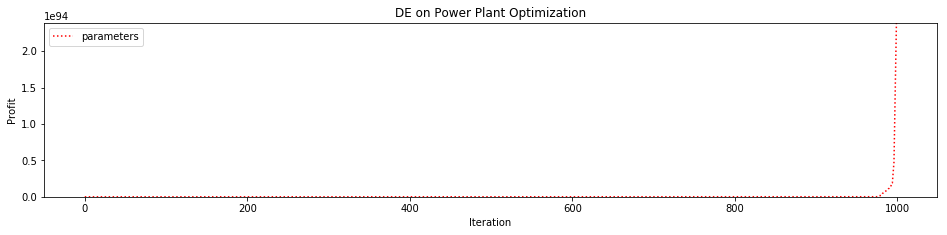

In [35]:
best_profit_per_run = best_solution_list
best_solution = max(best_solution_list)

print("Best solution in this run: ",best_solution)
simple_plot(best_profit_per_run,0,best_solution)